# Liquidity Risk Module — When Funding Dries Up

**Focus:** Understand **Liquidity Coverage Ratio (LCR)** and **Net Stable Funding Ratio (NSFR)**, build a **maturity ladder** of cash inflows/outflows, and model a **deposit run** stress. See how short‑term liquidity interacts with solvency.

> This notebook is an educational simplification — not regulatory reporting.

## Learning Objectives
- Construct a **maturity ladder** and cumulative cash‑flow gap curve.
- Compute **LCR** (30‑day stress: HQLA ÷ Net Cash Outflows) and **NSFR** (1‑year horizon).
- Model a **deposit run** (higher outflows, lower inflows/ASF) and compare to baseline.
- Link liquidity shortfalls to a **toy solvency impact** via HQLA haircuts / fire‑sale costs.

In [16]:
%pip install matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Setup

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')


## Parameters — Stylised Balance Sheet & Buckets

In [ ]:
# Time buckets (ordered)
BUCKETS = ['Overnight', '7D', '30D', '90D', '6M', '1Y', '>1Y']

# High Quality Liquid Assets (HQLA) — Level 1/2 haircuts (simplified)
HQLA = {
    'Level1 (0% haircut)': 60_000.0,
    'Level2A (15% haircut)': 15_000.0,
    'Level2B (50% haircut)': 8_000.0,
}

# Cash inflows by bucket (contractual, pre‑stress)
INFLOWS = {
    'Overnight': 8_000.0,
    '7D': 10_000.0,
    '30D': 12_000.0,
    '90D': 15_000.0,
    '6M': 18_000.0,
    '1Y': 22_000.0,
    '>1Y': 30_000.0,
}

# Cash outflows by bucket (pre‑stress)
OUTFLOWS = {
    'Overnight': 12_000.0,
    '7D': 14_000.0,
    '30D': 20_000.0,
    '90D': 17_000.0,
    '6M': 16_000.0,
    '1Y': 14_000.0,
    '>1Y': 10_000.0,
}

# ASF/RSF factors (very simplified Basel‑like)
ASF_FACTORS = {
    'Reg Stable Deposits': 0.95,
    'Other Retail Deposits': 0.90,
    'Wholesale <1Y': 0.50,
    'Wholesale ≥1Y': 1.00,
    'Equity & CET1': 1.00,
}

RSF_FACTORS = {
    'HQLA Level1': 0.00,
    'Loans <1Y': 0.50,
    'Loans ≥1Y': 0.85,
    'Non‑HQLA Securities': 0.50,
    'Derivatives & Other': 1.00,
}

# Available Stable Funding components (amounts)
ASF_AMOUNTS = {
    'Reg Stable Deposits': 120_000.0,
    'Other Retail Deposits': 80_000.0,
    'Wholesale <1Y': 60_000.0,
    'Wholesale ≥1Y': 40_000.0,
    'Equity & CET1': 30_000.0,
}

# Required Stable Funding components (amounts)
RSF_AMOUNTS = {
    'HQLA Level1': 20_000.0,
    'Loans <1Y': 100_000.0,
    'Loans ≥1Y': 180_000.0,
    'Non‑HQLA Securities': 50_000.0,
    'Derivatives & Other': 20_000.0,
}

# Toy solvency inputs
CET1 = 25_000.0
FIRE_SALE_COST_RATE = 0.10  # cost if liquidity shortfall forces distressed HQLA sales

## Helper Functions

In [ ]:
def hqla_after_haircut(hqla: dict) -> float:
    lvl1 = hqla.get('Level1 (0% haircut)', 0.0) * (1.0 - 0.00)
    lvl2a = hqla.get('Level2A (15% haircut)', 0.0) * (1.0 - 0.15)
    lvl2b = hqla.get('Level2B (50% haircut)', 0.0) * (1.0 - 0.50)
    return float(lvl1 + lvl2a + lvl2b)

def lcr(hqla_adj: float, inflows_30: float, outflows_30: float, inflow_cap: float = 0.75) -> float:
    # Net cash outflows over 30 days with 75% inflow cap (Basel rule of thumb)
    capped_inflows = min(inflows_30, outflows_30 * inflow_cap)
    net_out = max(outflows_30 - capped_inflows, 0.0)
    return hqla_adj / net_out if net_out > 0 else float('inf')

def nsfr(asf_amounts: dict, asf_factors: dict, rsf_amounts: dict, rsf_factors: dict) -> float:
    asf = sum(asf_amounts[k] * asf_factors.get(k, 0.0) for k in asf_amounts)
    rsf = sum(rsf_amounts[k] * rsf_factors.get(k, 0.0) for k in rsf_amounts)
    return asf / rsf if rsf > 0 else float('inf')

def maturity_ladder(inflows: dict, outflows: dict, buckets: list) -> pd.DataFrame:
    df = pd.DataFrame({'Bucket': buckets})
    df['Inflows'] = [float(inflows.get(b, 0.0)) for b in buckets]
    df['Outflows'] = [float(outflows.get(b, 0.0)) for b in buckets]
    df['Net'] = df['Inflows'] - df['Outflows']
    df['Cumulative Net'] = df['Net'].cumsum()
    return df

def deposit_run_stress(inflows: dict, outflows: dict, intensity: float = 0.25) -> tuple:
    # Increase near‑term outflows and haircut near‑term inflows
    stress_out = outflows.copy()
    stress_in = inflows.copy()
    for b in ['Overnight','7D','30D']:
        stress_out[b] = stress_out.get(b, 0.0) * (1.0 + 2.0*intensity)  # outsized early run
        stress_in[b] = stress_in.get(b, 0.0) * (1.0 - 0.6*intensity)
    # Later buckets moderate
    for b in ['90D','6M','1Y']:
        stress_out[b] = stress_out.get(b, 0.0) * (1.0 + 0.5*intensity)
        stress_in[b] = stress_in.get(b, 0.0) * (1.0 - 0.2*intensity)
    return stress_in, stress_out

def toy_solvency_impact(cet1: float, liquidity_shortfall: float, fire_sale_rate: float) -> float:
    # If net 30‑day outflows exceed HQLA, fire‑sale cost reduces CET1
    return max(cet1 - liquidity_shortfall * fire_sale_rate, 0.0)

## Baseline: Ladder, LCR, NSFR

In [ ]:
ladder_base = maturity_ladder(INFLOWS, OUTFLOWS, BUCKETS)

# 30‑day inflows/outflows = Overnight + 7D + 30D
in_30 = ladder_base.loc[ladder_base['Bucket'].isin(['Overnight','7D','30D']), 'Inflows'].sum()
out_30 = ladder_base.loc[ladder_base['Bucket'].isin(['Overnight','7D','30D']), 'Outflows'].sum()

hqla_adj = hqla_after_haircut(HQLA)
LCR_base = lcr(hqla_adj, in_30, out_30)
NSFR_base = nsfr(ASF_AMOUNTS, ASF_FACTORS, RSF_AMOUNTS, RSF_FACTORS)

baseline_summary = pd.Series({
    'HQLA (post‑haircut) (£)': hqla_adj,
    '30D Inflows (£)': in_30,
    '30D Outflows (£)': out_30,
    'LCR (x)': LCR_base,
    'NSFR (x)': NSFR_base,
}, name='Baseline')

ladder_base, baseline_summary

(      Bucket   Inflows  Outflows       Net  Cumulative Net
 0  Overnight  8,000.00 12,000.00 -4,000.00       -4,000.00
 1         7D 10,000.00 14,000.00 -4,000.00       -8,000.00
 2        30D 12,000.00 20,000.00 -8,000.00      -16,000.00
 3        90D 15,000.00 17,000.00 -2,000.00      -18,000.00
 4         6M 18,000.00 16,000.00  2,000.00      -16,000.00
 5         1Y 22,000.00 14,000.00  8,000.00       -8,000.00
 6        >1Y 30,000.00 10,000.00 20,000.00       12,000.00,
 HQLA (post‑haircut) (£)   76,750.00
 30D Inflows (£)           30,000.00
 30D Outflows (£)          46,000.00
 LCR (x)                        4.80
 NSFR (x)                       1.15
 Name: Baseline, dtype: float64)

### Cumulative Cash‑Flow Gap (Baseline)

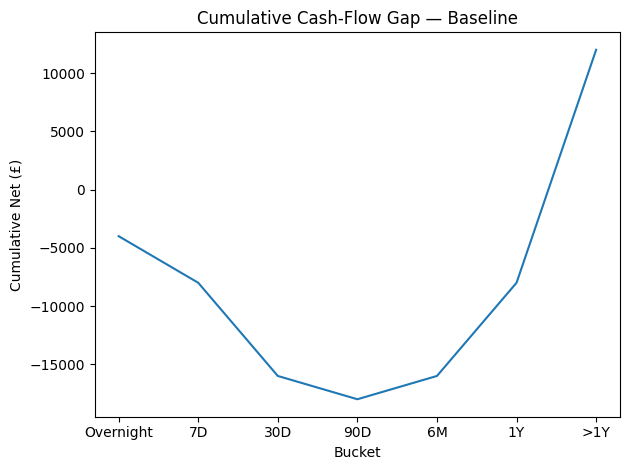

In [ ]:
plt.figure()
plt.plot(ladder_base['Bucket'], ladder_base['Cumulative Net'])
plt.title('Cumulative Cash‑Flow Gap — Baseline')
plt.xlabel('Bucket')
plt.ylabel('Cumulative Net (£)')
plt.tight_layout()
plt.show()

## Deposit Run Stress

In [22]:
INFLOWS_stress, OUTFLOWS_stress = deposit_run_stress(INFLOWS, OUTFLOWS, intensity=0.35)
ladder_stress = maturity_ladder(INFLOWS_stress, OUTFLOWS_stress, BUCKETS)

in_30_s = ladder_stress.loc[ladder_stress['Bucket'].isin(['Overnight','7D','30D']), 'Inflows'].sum()
out_30_s = ladder_stress.loc[ladder_stress['Bucket'].isin(['Overnight','7D','30D']), 'Outflows'].sum()

LCR_stress = lcr(hqla_adj, in_30_s, out_30_s)
NSFR_stress = nsfr(
    {k: (ASF_AMOUNTS[k] * (0.9 if 'Deposits' in k else 1.0)) for k in ASF_AMOUNTS},  # assume some ASF erosion on deposits
    ASF_FACTORS,
    RSF_AMOUNTS,
    RSF_FACTORS
)

# Liquidity shortfall over 30 days
capped_inflows_s = min(in_30_s, out_30_s * 0.75)
net_out_s = max(out_30_s - capped_inflows_s, 0.0)
liq_shortfall = max(net_out_s - hqla_adj, 0.0)
CET1_post = toy_solvency_impact(CET1, liq_shortfall, FIRE_SALE_COST_RATE)

stress_summary = pd.Series({
    'HQLA (post‑haircut) (£)': hqla_adj,
    '30D Inflows (£)': in_30_s,
    '30D Outflows (£)': out_30_s,
    'Net Outflows 30D (capped inflows) (£)': net_out_s,
    'LCR (x)': LCR_stress,
    'NSFR (x)': NSFR_stress,
    'Liquidity Shortfall (£)': liq_shortfall,
    'CET1 pre‑stress (£)': CET1,
    'CET1 post fire‑sale cost (£)': CET1_post,
}, name='Deposit Run Stress')

ladder_stress, stress_summary


(      Bucket   Inflows  Outflows        Net  Cumulative Net
 0  Overnight  6,320.00 20,400.00 -14,080.00      -14,080.00
 1         7D  7,900.00 23,800.00 -15,900.00      -29,980.00
 2        30D  9,480.00 34,000.00 -24,520.00      -54,500.00
 3        90D 13,950.00 19,975.00  -6,025.00      -60,525.00
 4         6M 16,740.00 18,800.00  -2,060.00      -62,585.00
 5         1Y 20,460.00 16,450.00   4,010.00      -58,575.00
 6        >1Y 30,000.00 10,000.00  20,000.00      -38,575.00,
 HQLA (post‑haircut) (£)                 76,750.00
 30D Inflows (£)                         23,700.00
 30D Outflows (£)                        78,200.00
 Net Outflows 30D (capped inflows) (£)   54,500.00
 LCR (x)                                      1.41
 NSFR (x)                                     1.08
 Liquidity Shortfall (£)                      0.00
 CET1 pre‑stress (£)                     25,000.00
 CET1 post fire‑sale cost (£)            25,000.00
 Name: Deposit Run Stress, dtype: float64)

### Cumulative Cash‑Flow Gap (Stress)

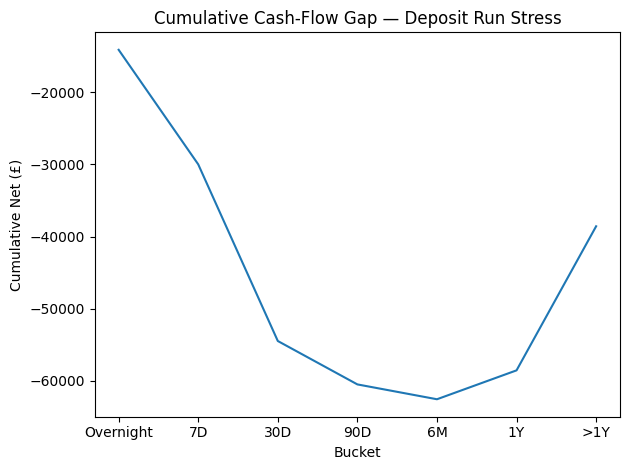

In [ ]:
plt.figure()
plt.plot(ladder_stress['Bucket'], ladder_stress['Cumulative Net'])
plt.title('Cumulative Cash‑Flow Gap — Deposit Run Stress')
plt.xlabel('Bucket')
plt.ylabel('Cumulative Net (£)')
plt.tight_layout()
plt.show()

## Compare LCR & NSFR — Baseline vs Stress

In [ ]:
compare = pd.DataFrame([baseline_summary, stress_summary]).T
compare

,Baseline,Deposit Run Stress
HQLA (post‑haircut) (£),"76,750.00","76,750.00"
30D Inflows (£),"30,000.00","23,700.00"
30D Outflows (£),"46,000.00","78,200.00"
LCR (x),4.80,1.41
NSFR (x),1.15,1.08
Net Outflows 30D (capped inflows) (£),NaN,"54,500.00"
Liquidity Shortfall (£),NaN,0.00
CET1 pre‑stress (£),NaN,"25,000.00"
CET1 post fire‑sale cost (£),NaN,"25,000.00"


## Export Key Tables

In [25]:
ladder_base.to_csv('liquidity_ladder_baseline.csv', index=False)
ladder_stress.to_csv('liquidity_ladder_stress.csv', index=False)
compare.to_csv('liquidity_lcr_nsfr_compare.csv')


---
### Notes
- **LCR**: HQLA divided by 30‑day net cash outflows (inflows capped at 75% of outflows).
- **NSFR**: Available Stable Funding ÷ Required Stable Funding over a 1‑year horizon.
- Deposit run stress increases near‑term outflows and reduces inflows/ASF to mimic behavioural pressure.
- To extend: add contingent liquidity (undrawn lines), secured funding with haircuts, and central bank facilities.